In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import unicodedata
import nltk

import os
import time
import re

import acquire
import prepare

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-whitegrid')
sns.set_palette('twilight')
# sns.color_palette("cubehelix", as_cmap=True)
plt.rc('font', size=16)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Acquire

Pull cleaned, and prepped data saved to csv

In [2]:
# use csv cereated by team
df = pd.read_csv('NLP.csv')
df.drop(columns = 'Unnamed: 0', inplace=True)
df.sample(5)

,repo,language,readme_contents,clean,stemmed,lemmatized
114,bananiumbot/bot,JavaScript,# bananium bot\n\n[![Build Status](https://img...,bananium bot build statushttpsimgshieldsiotrav...,bananium bot build statushttpsimgshieldsiotrav...,bananium bot build statushttpsimgshieldsiotrav...
148,strorinWind/bot,Python,NaN,NaN,NaN,NaN
76,Roibal/Cryptocurrency-Trading-Bots-Python-Begi...,Python,# Cryptocurrency / Bitcoin Trading Bots in Pyt...,cryptocurrency bitcoin trading bots python alg...,cryptocurr bitcoin trade bot python algo autom...,cryptocurr bitcoin trade bot python algo autom...
132,gillesheinesch/LenoxBot,JavaScript,# LenoxBot\n\n> LenoxBot is a Discord bot that...,lenoxbot lenoxbot discord bot offers many cool...,lenoxbot lenoxbot discord bot offer mani cool ...,lenoxbot lenoxbot discord bot offer mani cool ...
115,aws-samples/aws-lex-web-ui,JavaScript,# Transfer to Amazon Connect Live Chat\n\nThis...,transfer amazon connect live chat feature allo...,transfer amazon connect live chat featur allow...,transfer amazon connect live chat featur allow...


# Feature enginieer 

In [3]:
# change df.language to lower case
df['language'] = df["language"].str.lower()

In [4]:
# create column with count of characters in clean message
df['character_count'] = df.clean.str.len()
# create column with count of worlds in clean message
df['word_count'] =  df.clean.str.count(' ').add(1)

# create column with count of worlds in clean message
df['stemmed_word_count'] =  df.stemmed.str.count(' ').add(1)
df['lemmatized_word_count'] =  df.lemmatized.str.count(' ').add(1)

In [5]:
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count,stemmed_word_count,lemmatized_word_count
0,python-discord/bot,python,# Python Utility Bot\n\n[![Discord][7]][8]\n[!...,python utility bot discord78 lint test12 build...,python util bot discord78 lint test12 build34 ...,python util bot discord78 lint test12 build34 ...,986.0,53.0,53.0,53.0
1,microsoft/BotBuilder-Samples,javascript,\r\n# ![Bot Framework Samples](./docs/media/Bo...,bot framework samplesdocsmediabotframeworksamp...,bot framework samplesdocsmediabotframeworksamp...,bot framework samplesdocsmediabotframeworksamp...,17051.0,1070.0,1070.0,1070.0
2,GAwesomeBot/bot,javascript,# GAwesomeBot\n[![Travis Status](https://travi...,gawesomebot travis statushttpstravisciorggilbe...,gawesomebot travi statushttpstravisciorggilber...,gawesomebot travi statushttpstravisciorggilber...,1767.0,134.0,134.0,134.0
3,roughike/BottomBar,java,# BottomBar (Deprecated)\n\nI don't have time ...,bottombar deprecated dont time maintain anymor...,bottombar deprec dont time maintain anymor bas...,bottombar deprec dont time maintain anymor bas...,11377.0,904.0,904.0,904.0
4,mithun-prasad/Bot,c#,# Developing and Deploying Intelligent Chat Bo...,developing deploying intelligent chat bots tra...,develop deploy intellig chat bot train resourc...,develop deploy intellig chat bot train resourc...,1839.0,240.0,240.0,240.0


In [6]:
# count the records that have a ddiffernece in word count of stemmed vs lemmatized
(df.stemmed_word_count != df.lemmatized_word_count).sum()

3

In [7]:
df.sample()

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count,stemmed_word_count,lemmatized_word_count
208,viperadnan-git/force-subscribe-telegram-bot,python,# Introduction\n**A Telegram Bot to force user...,introduction telegram bot force users join spe...,introduct telegram bot forc user join specif c...,introduct telegram bot forc user join specif c...,769.0,70.0,70.0,70.0


In [8]:
df = df.drop(columns=['stemmed_word_count', 'lemmatized_word_count'])

# Takeaway 
- There is no significant difference in the word count of stemmed vs lemmatized
    - drop newly created columns
-------------

# Exploration


In [9]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "language")

,n,percent
python,112,0.491228
javascript,55,0.241228
java,24,0.105263
c#,20,0.087719
typescript,17,0.074561


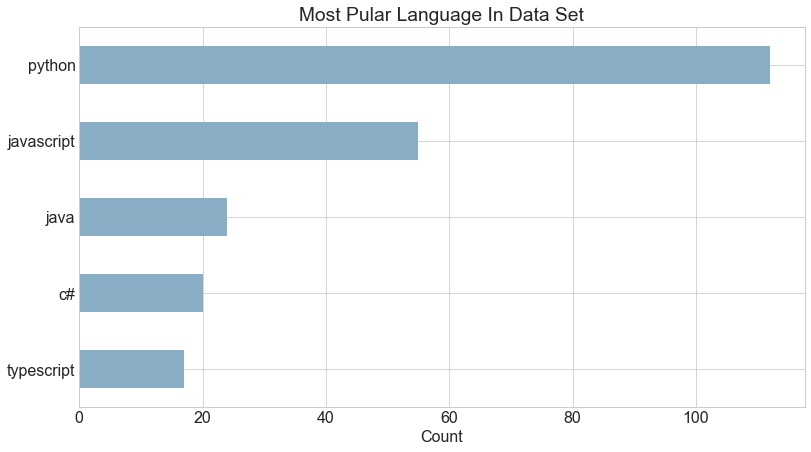

In [10]:
# create bar graph withthe count of lenguages of datafreame 
df.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Most Pular Language In Data Set')
plt.xlabel("Count")
plt.show()

### <center>Esplit data before into Train, Validate, and Test before exploring multiple variables together<center>

In [11]:
train, validate, test = prepare.split_data(df)

In [12]:
print ('train    ===>', train.shape)
print ('validate ===>', validate.shape)
print('test     ===>', test.shape)

train    ===> (127, 8)
validate ===> (55, 8)
test     ===> (46, 8)


In [13]:
# create a df with language information based on character_count
message_length_info_train = train[['language','character_count']].\
                            groupby('language').agg(['mean', 'min', 'max', 'std' ])
message_length_info_train

character_count                             
                      mean    min      max          std
language                                               
c#             4063.750000   40.0  18281.0  5029.486981
java           4608.769231  262.0  11377.0  3549.852207
javascript     3823.769231   40.0  17051.0  3896.513111
python         3302.419355   46.0  17962.0  3783.857835
typescript     2778.909091   51.0  10180.0  2867.422203

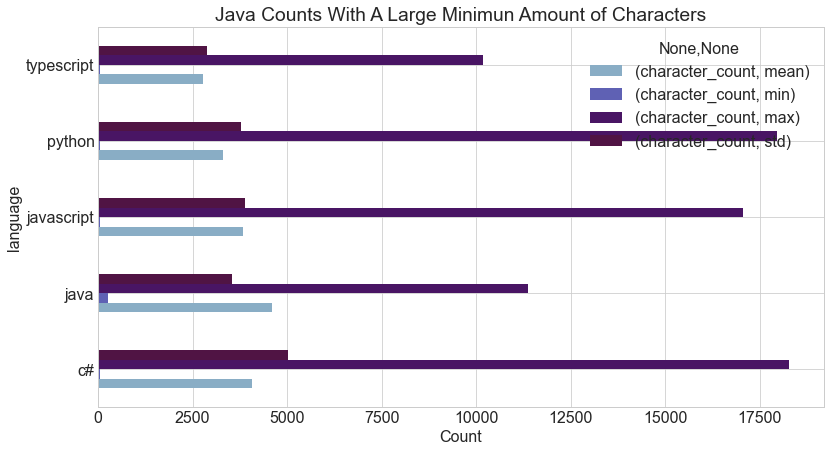

In [14]:
# creaet bar plot for  message_lenth_info_df 
message_length_info_train.plot.barh()
plt.title('Java Counts With A Large Minimun Amount of Characters')
plt.xlabel("Count")
plt.show()

In [15]:
# create a df with language information based on word_count
word_count_info_train = train[['language','word_count']].\
                        groupby('language').agg(['mean', 'min', 'max', 'std' ])
word_count_info_train

word_count                          
                  mean   min     max         std
language                                        
c#          330.333333   5.0  1282.0  357.315835
java        413.538462  25.0   904.0  298.614192
javascript  363.307692   5.0  1201.0  321.745834
python      358.096774   4.0  2058.0  431.876907
typescript  225.454545   7.0   519.0  164.272556

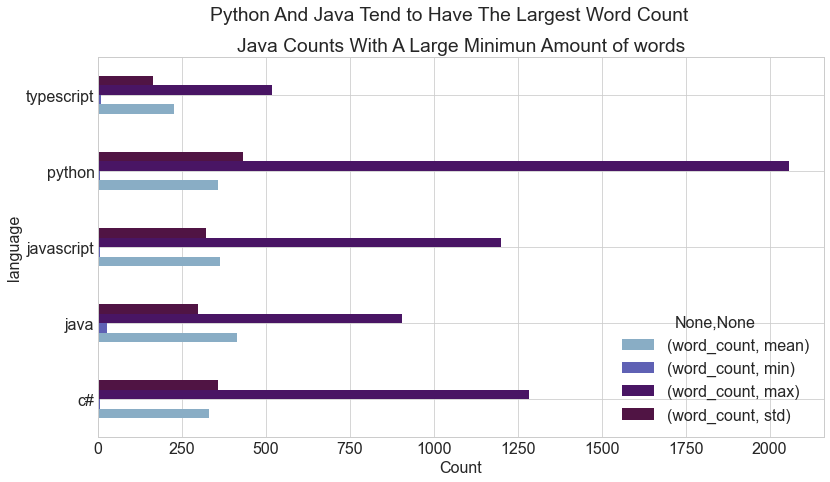

In [16]:
word_count_info_train.plot.barh()
plt.title('Java Counts With A Large Minimun Amount of words')
plt.suptitle('Python And Java Tend to Have The Largest Word Count')
plt.xlabel("Count")
plt.show()

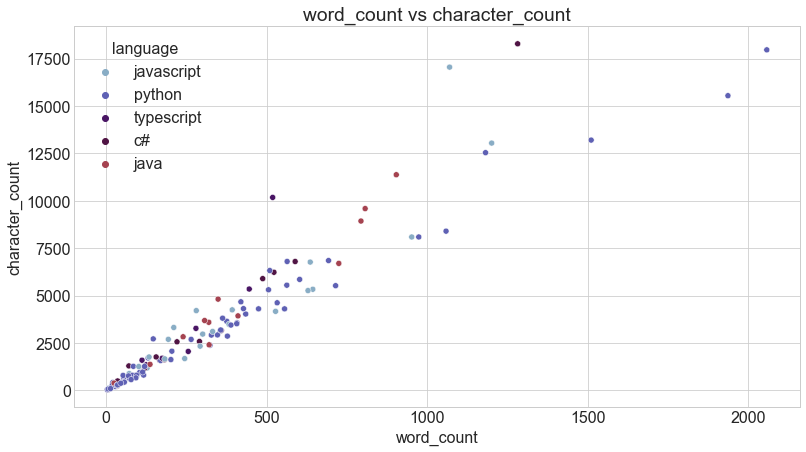

In [17]:
# create scatter plot for word_count and Character_count
x = 'word_count'
y = 'character_count'
plt.title(f"{x} vs {y}")
sns.scatterplot(data=train, x=train[x], y=train[y], hue='language')
plt.show()

# Takeaway

## NEED UPDATE

- TypeScript has the lowest standar diviation of charaters and word counts 
- JavaScrip has the largest average word count and secong largest mean for characters 
- Java has a large min amount of characters and word counts 
-
-


------------------------

In [18]:
df.shape

(228, 8)

In [19]:
# Create datafreames containing only one languageb
# creating dfs
df_python = train[train.language == 'python']
df_js = train[train.language == 'javaScript']
df_java = train[train.language == 'java']
df_c = train[train.language == 'c#']
df_type = train[train.language == 'typescript']

In [20]:
df_type.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count
87,line/line-bot-sdk-nodejs,typescript,# LINE Messaging API SDK for nodejs\n\n[![Trav...,line messaging api sdk nodejs travis cihttpstr...,line messag api sdk nodej travi cihttpstravisc...,line messag api sdk nodej travi cihttpstravisc...,1355.0,125.0
128,Malexion/Rhythm-Bot,typescript,# Rhythm-Bot 2.1.5 Search / Rich Text / Button...,rhythmbot 215 search rich text buttons new sea...,rhythmbot 215 search rich text button new sear...,rhythmbot 215 search rich text button new sear...,2059.0,256.0
13,FireDiscordBot/bot,typescript,hi i will eventually add things here but for n...,hi eventually add things httpsinvwtfbot invite...,hi eventu add thing httpsinvwtfbot invit fire,hi eventu add thing httpsinvwtfbot invit fire,51.0,7.0
215,tgcallsjs/LemonJamsBot,typescript,# LemonJamsBot\n\n## Setup\n\n- Install youtub...,lemonjamsbot setup install youtubedl fill env ...,lemonjamsbot setup instal youtubedl fill env g...,lemonjamsbot setup instal youtubedl fill env g...,228.0,34.0
32,microsoft/BotFramework-Composer,typescript,# ![Microsoft Bot Framework Composer](./docs/A...,microsoft bot framework composerdocsassetsghba...,microsoft bot framework composerdocsassetsghba...,microsoft bot framework composerdocsassetsghba...,5350.0,446.0


# Takeaways 
- Python seems to have the the lrgest cconvination of characters and word count
- Java seems to have more characters without the need of a lot of words


In [21]:
train.sample()

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count
170,CrazyBotsz/Adv-Auto-Filter-Bot,python,"# Adv Auto Filter Bot\r\n\r\n<p align=""center""...",adv auto filter bot p aligncenter hrefhttpsgit...,adv auto filter bot p aligncent hrefhttpsgithu...,adv auto filter bot p aligncent hrefhttpsgithu...,419.0,21.0


In [25]:
# generating text strings for each df
all_words = ' '.join(train.lemmatized.astype(str))
python_words = ' '.join(df_python.lemmatized.astype(str))
js_words = ' '.join(df_js.lemmatized.astype(str))
java_words = ' '.join(df_java.lemmatized.astype(str))
c_words = ' '.join(df_c.lemmatized.astype(str))
typescript_words = ' '.join(df_type.lemmatized.astype(str))

''

In [23]:
# creating a df for the word count and frequency
# word count
df_all_count = pd.DataFrame(pd.Series(all_words.split()).value_counts(), columns = ['all_word_cnt'])
# word frequency
df_all_count['all_word_freq'] = pd.Series(all_words.split()).value_counts(normalize = True)

# df view
df_all_count.head(10)

,all_word_cnt,all_word_freq
bot,886,0.020381
use,700,0.016103
instal,379,0.008718
file,278,0.006395
run,266,0.006119
python,256,0.005889
set,249,0.005728
support,237,0.005452
user,204,0.004693
get,199,0.004578


In [55]:
# creating a df for the word count and frequency
# word count
df_python_count = pd.DataFrame(pd.Series(python_words.split()).value_counts(), columns = ['python_word_cnt']).head(50)

# word frequency
df_python_count['python_word_freq'] = pd.Series(python_words.split()).value_counts(normalize = True).head(50)

# df view
df_python_count

,python_word_cnt,python_word_freq
bot,418,0.018825
use,341,0.015358
instal,264,0.011890
python,248,0.011169
file,213,0.009593
run,159,0.007161
support,139,0.006260
account,130,0.005855
option,117,0.005269
user,117,0.005269


In [56]:
# creating a df for the word count and frequency
# word count
df_js_count = pd.DataFrame(pd.Series(js_words.split()).value_counts(), columns = ['js_word_cnt']).head(50)

# word frequency
df_js_count['js_word_freq'] = pd.Series(js_words.split()).value_counts(normalize = True).head(50)

# df view
df_js_count

,js_word_cnt,js_word_freq


In [50]:
len(python_words.split())

22204